# TigerGraph Graph Data Science Library 101 - Graph Embedding 

This notebook shows the examples of using graph embedding algorithms in TigerGraph Graph Science Library. More detailed explanations of these algorithms can be four in the official documentation 
(https://docs.tigergraph.com/graph-ml/current/node-embeddings/).  

## Step 1: Load Cora graph data

In [1]:
import json
config_file = open ('../config.json', "r")
config = json.load(config_file)
config_file.close()

In [2]:
from pyTigerGraph.datasets import Datasets

dataset = Datasets("Cora")

Downloading:   0%|          | 0/166537 [00:00<?, ?it/s]

In [3]:
from pyTigerGraph import TigerGraphConnection
import json

conn = TigerGraphConnection(
    host=config["host"],
    username=config["username"],
    password=config["password"],
)

In [4]:
conn.ingestDataset(dataset, getToken=config["getToken"])

---- Checking database ----
A graph with name Cora already exists in the database. Skip ingestion.


In [5]:
from pyTigerGraph.visualization import drawSchema

drawSchema(conn.getSchema(force=True))

CytoscapeWidget(cytoscape_layout={'name': 'circle', 'animate': True, 'padding': 1}, cytoscape_style=[{'selecto…

## Step 2: Running Louvain Community Detection
We are going to use the pyTigerGraph featurizer to run Louvain community detection on the citation network.

In [6]:
feat = conn.gds.featurizer()

params = {
    "v_type_set": "Paper",
    "e_type_set": "Cite",
    "weight_attribute": "",
    "maximum_iteration": 10,
    "result_attribute": "community_id",
    "file_path": "",
    "print_stats": True
}

feat.runAlgorithm("tg_louvain", params = params)

[{'AllVertexCount': 2708},
 {'InitChangeCount': 0},
 {'VertexFollowedToCommunity': 371},
 {'VertexFollowedToVertex': 114},
 {'VertexAssignedToItself': 0},
 {'FinalCommunityCount': 2280}]

## Step 3: Leveraging pyTigerGraph’s featurizer to run embedding algorithms

pyTIgerGraph provides a full suit of data science capabilities, and in this tutorial, we will showcase how to use featurizer to run a few popular algorithms as an example.

In [7]:
feat.listAlgorithms("Embeddings")

Available algorithms for Embeddings:
  FastRP:
    01. name: tg_fastRP
Call runAlgorithm() with the algorithm name to execute it


### Install and run fastRP algorithm 

Fast Random Projection (FastRP) is a scalable and performant node-embedding algorithm. It generates node embeddings (vectors) of low dimensionality through random projections from the graph’s adjacency matrix (a high-dimensional matrix) to a low-dimensional matrix, significantly reducing the computing power required to process the data. (https://docs.tigergraph.com/graph-ml/current/node-embeddings/fast-random-projection)

In [8]:
params={"v_type_set": ["Paper"],
        "e_type_set": ["Cite"],
        "output_v_type_set": ["Paper"],
        "iteration_weights": "1,2,4",
        "beta": -0.1,
        "embedding_dimension": 128,
        "embedding_dim_map": [],
        "default_length": 128,
        "sampling_constant": 3,
        "random_seed": 42,
        "component_attribute": "",
        "result_attribute": "embedding",
        "choose_k": 0}

feat.runAlgorithm("tg_fastRP", params=params)

[{'@@embedding_dim_map': {'default': {'min_dim': 0,
    'max_dim': 128,
    'weight': 1}}},
 {'sample_verts': []}]

In [9]:
df = conn.getVertexDataFrame("Paper")

In [10]:
df.head()

,v_id,id,x,y,train_mask,val_mask,test_mask,community_id,embedding
0,2696,2696,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,False,False,True,689963009,"[-0.22738, -0.32103, 0.23506, -0.40459, -0.011..."
1,2688,2688,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,False,False,True,770703361,"[0, -0.03219, 0.1719, 0.46644, 0, 0.18486, 0, ..."
2,2656,2656,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,False,False,True,770703362,"[-0.18878, 0.27308, 0.04562, 0.10869, 0.24994,..."
3,2649,2649,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,False,False,True,770703363,"[0.07591, -0.19048, 0.04639, -0.192, 0.1164, -..."
4,2646,2646,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,False,False,True,635437099,"[-0.24409, 0.12149, 0.12944, 0.50041, -0.25728..."


In [11]:
import pandas as pd

pd.DataFrame(df['community_id'].value_counts()).value_counts().sort_index()

community_id
1               1925
2                314
3                 29
4                  7
5                  3
12                 1
13                 1
dtype: int64

### Compute intra- and inter-communities similarities for FastRP embeddings using Louvain Communities

In [12]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

cnt = 5
comms_list = ['community_id']

for comm in comms_list:
    print(f"***Community Detection ID: {comm}***\n")
    
    comm_embs = None
    print("Intra-community similarities:\n")

    for i, c_id in enumerate(df[comm].value_counts().head(cnt).index):
        community = df[df[comm] == c_id]
        comm_embs = np.stack(community["embedding"].values)
        similarities = cosine_similarity(comm_embs)
        print(f"Community: {i}")
        print(f"Number of members in community: {len(comm_embs)}")
        print(f"Mean intra-community similarity: {similarities.mean()}")
        print(f"Std. Dev. of intra-community similarity: {np.std(similarities)}")
        print()

    print("Inter-community similarities:\n")

    for i, c_id in enumerate(df[comm].value_counts().head(cnt).index):
        community = df[df[comm] == c_id]
        comm_embs_comp = comm_embs
        comm_embs = np.stack(community["embedding"].values)

        if i >= 1:
            similarities = cosine_similarity(comm_embs_comp, comm_embs)
            print(f"Communities: {i-1}-{i}")
            print(f"Mean inter-community similarity: {similarities.mean()}")
            print(f"Std. Dev. of intra-community similarity: {np.std(similarities)}")
            print()

***Community Detection ID: community_id***

Intra-community similarities:

Community: 0
Number of members in community: 13
Mean intra-community similarity: 0.997070929902624
Std. Dev. of intra-community similarity: 0.0071995963055932356

Community: 1
Number of members in community: 12
Mean intra-community similarity: 0.9974883667342174
Std. Dev. of intra-community similarity: 0.005914592135088319

Community: 2
Number of members in community: 5
Mean intra-community similarity: 0.9985160220792991
Std. Dev. of intra-community similarity: 0.0021632509671548937

Community: 3
Number of members in community: 5
Mean intra-community similarity: 0.9887536544221532
Std. Dev. of intra-community similarity: 0.016394225014307873

Community: 4
Number of members in community: 5
Mean intra-community similarity: 0.9967383040968224
Std. Dev. of intra-community similarity: 0.0047546979767608

Inter-community similarities:

Communities: 0-1
Mean inter-community similarity: -0.025874418882637314
Std. Dev. o

In [13]:
# Grab embeddings for Louvain Communities

c_id0 = df["community_id"].value_counts().head(25).index[0]
c_id1 = df["community_id"].value_counts().head(25).index[1]
c_id2 = df["community_id"].value_counts().head(25).index[2]
c_id3 = df["community_id"].value_counts().head(25).index[3]
c_id4 = df["community_id"].value_counts().head(25).index[4]

community0 = df[df["community_id"] == c_id0]
comm_embs0 = np.stack(community0["embedding"].values)

community1 = df[df["community_id"] == c_id1]
comm_embs1 = np.stack(community1["embedding"].values)

community2 = df[df["community_id"] == c_id2]
comm_embs2 = np.stack(community2["embedding"].values)

community3 = df[df["community_id"] == c_id3]
comm_embs3 = np.stack(community3["embedding"].values)

community4 = df[df["community_id"] == c_id4]
comm_embs4 = np.stack(community4["embedding"].values)

X = np.vstack((comm_embs0, comm_embs1, comm_embs2, comm_embs3, comm_embs4))

y0 = np.ones((comm_embs0.shape[0])) * 0
y1 = np.ones((comm_embs1.shape[0])) * 1
y2 = np.ones((comm_embs2.shape[0])) * 2
y3 = np.ones((comm_embs3.shape[0])) * 3
y4 = np.ones((comm_embs4.shape[0])) * 4
y = np.hstack((y0,y1,y2,y3,y4))

### Plot embeddings in 2D space

In [14]:
!pip install umap
!pip install umap-learn
!pip install seaborn

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=161a136fabd480d557ae1cacbdbf9b13ea5b9cdaabd23a25a1bfeb86efb9598e
  Stored in directory: /home/tigergraph/.cache/pip/wheels/0f/d2/29/4d21dda3eb23f4eb42bc340a0e0282333539015afc8082a7b2
Successfully built umap
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 60.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 43.7 MB/s eta 0:00:0000:0100:01
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82813 sha256=60afa34b1a6a451d9ecbac138897533ae25d8ef9efd841239a71d782d21ea846
  Stored in directory: /home/tigergraph/.cache/pip/wheels/fb/99/10/ed2f3bc57ea29f540470eb43570

In [15]:
import umap.umap_ as umap

embd_x = umap.UMAP().fit_transform(X)

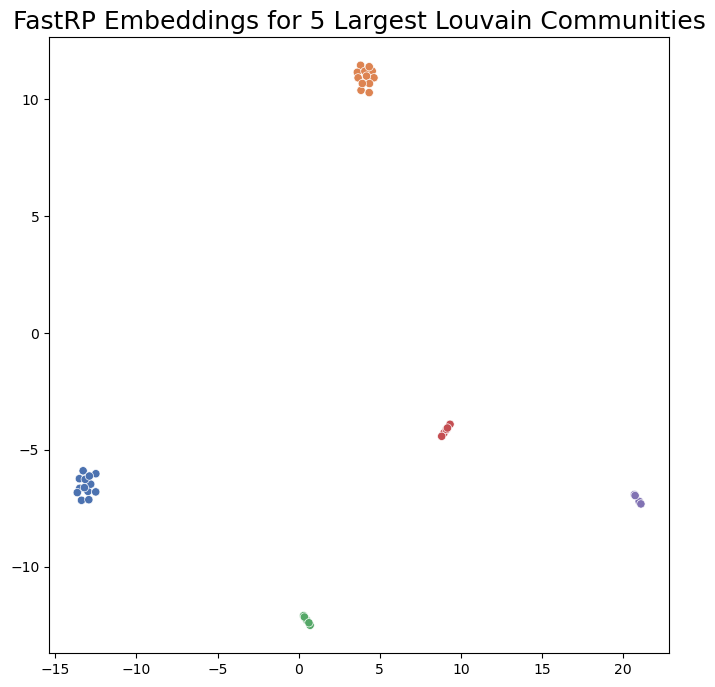

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
sns.set(font_scale=1)

palette = {}
for n, i in enumerate(set([0, 1, 2, 3, 4])):
    palette[i] = f'C{n}'
    
sns.scatterplot(ax=axs, x=embd_x.T[0], y=embd_x.T[1], hue=y, palette=palette)
axs.get_legend().remove()
plt.title("FastRP Embeddings for 5 Largest Louvain Communities", fontsize=18)

plt.show()